# Calculating R^2 point values for CNN


* all the different downscaling datasets vs obs (“signal files” in rain days notebook)
* Dataset downscaling ERA-Int
* all values in May
* 20 SGP points, starting with x098, y36
* Include regression line
* Annotate with gridcell, simulation, period, R^2, RMSE
* Also calculate pearson & spearman correlations
* Other statistical tests of timeseries similarity?

### TODO items

* better graphs (i.e. include lat/lon scale)

In [1]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import spearmanr

# Paths

In [2]:
cnn_sigfiles = ['prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x094.y32.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x094.y34.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x094.y36.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x094.y38.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x096.y32.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x096.y34.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x096.y36.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x096.y38.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y32.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y34.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y38.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x100.y32.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x100.y34.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x100.y36.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x100.y38.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x102.y32.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x102.y34.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x102.y36.nc', 'prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x102.y38.nc']
cnn_dirpath = '/glade/work/mcginnis/DCA/data/gen/new-sdsm/old/mpi/hist/'
#obs_sigfiles
rainsignal_obs = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc')['prec']
rainsignal = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc')['prec']

In [186]:
# plots 

def linear_regression(x, y): 
    coefs = np.polynomial.polynomial.polyfit(x, y, 1)
    ffit = np.poly1d(coefs)
    m = ffit[0]
    b = ffit[1] 
    eq = 'y = {}x + {}'.format(round(m, 3), round(b, 3))
    pc = np.corrcoef(x, y)[0, 1]
                  
    return pc, eq, m, b

        
def moving_avg(signal, swath=20):
    return np.convolve(signal, np.ones(swath)/swath, mode='valid')


from os.path import basename
def plot_avg_r2(sigfile, obs_sigfile, ndays):     
    # load rain signal
    rainsignal = xr.open_dataset(sigfile)['prec']
    sigfilename = basename(sigfile)
    
    # load obs
    rainsignal_obs = xr.open_dataset(obs_sigfile)['prec']


    rs1 = np.array(rainsignal_obs[:,0,0])
    rs2 = np.array(rainsignal[:,0,0])
    
    # fix rs2: set nan's to zero
    rs1[np.isnan(rs1)] = 0.
    rs2[np.isnan(rs2)] = 0.

    # smooth with 100 day running average    
    rs1 = moving_avg(rs1, ndays)
    rs2 = moving_avg(rs2, ndays)
    

    print ("model:", sigfilename)


    # plot best fit line
    pc, eq, m, b = linear_regression(rs1,rs2)
    xmaxreg = max(rs1)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(rs2): 
        xmaxreg = (max(rs2)-b) / m
    plt.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    rowtitle = '.'.join(sigfilename.split('.')[0:4])
    plt.scatter(rs1, rs2, color="tab:blue", s=1, label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(rs1,rs2)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((rs1-rs2)**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    plt.legend(loc="upper right", title=r2_text)

    # title
    sigfilename = basename(sigfile)
    title = sigfilename.split('.')[5] + ' ' + '.'.join(sigfilename.split('.')[7:10])
    plt.title( title.upper()+' vs. obs' )
                
                

    plt.show()
    
    
def plot_row_avg_r2(sigfile, obs_sigfile, ndays, ax):     
    # load rain signal
    rainsignal = xr.open_dataset(sigfile)['prec']
    sigfilename = basename(sigfile)
    
    # load obs
    rainsignal_obs = xr.open_dataset(obs_sigfile)['prec']


    rs1 = np.array(rainsignal_obs[:,0,0])
    rs2 = np.array(rainsignal[:,0,0])
    
    # fix rs2: set nan's to zero
    rs1[np.isnan(rs1)] = 0.
    rs2[np.isnan(rs2)] = 0.

    # smooth with 100 day running average    
    rs1 = moving_avg(rs1, ndays)
    rs2 = moving_avg(rs2, ndays)
    

    print ("model:", sigfilename)


    # plot best fit line
    pc, eq, m, b = linear_regression(rs1,rs2)
    xmaxreg = max(rs1)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(rs2): 
        xmaxreg = (max(rs2)-b) / m
    ax.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    rowtitle = '.'.join(sigfilename.split('.')[0:4])
    ax.scatter(rs1, rs2, color="tab:blue", s=1, label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(rs1,rs2)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((rs1-rs2)**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    ax.legend(loc="upper right", title=r2_text)

    # title
    sigfilename = basename(sigfile)
    title = sigfilename.split('.')[5] + ' ' + '.'.join(sigfilename.split('.')[7:10])
    #ax.title( title.upper()+' vs. obs' )
    ax.set_title(title.upper()+' vs. obs')
                
    #plt.show()
    
    

dry: hist
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc


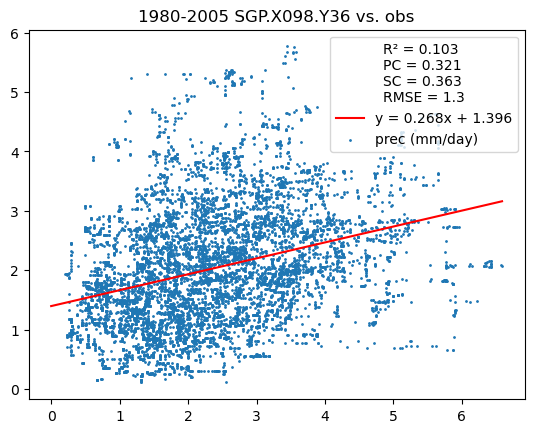

In [101]:
# mpi dry: hist
print("dry: hist")
#sigfiles_hist = list(filter(lambda line:'hist' in line, sigfiles))
s1 = '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc'
s2 = '/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc'
plot_avg_r2(s1,s2, 90) 


# Plot all 20 grid points

In [31]:
plot_row_avg_r2(s1, s2, 30, axarr[0])

model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y32.nc


model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y32.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y32.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y32.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y32.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y32.nc


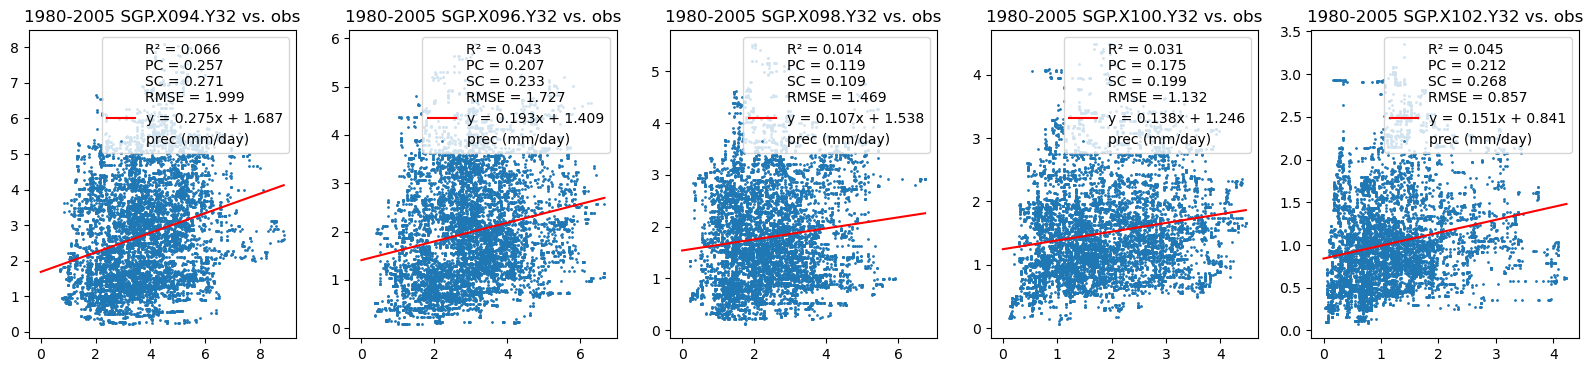

model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y34.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y34.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y34.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y34.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y34.nc


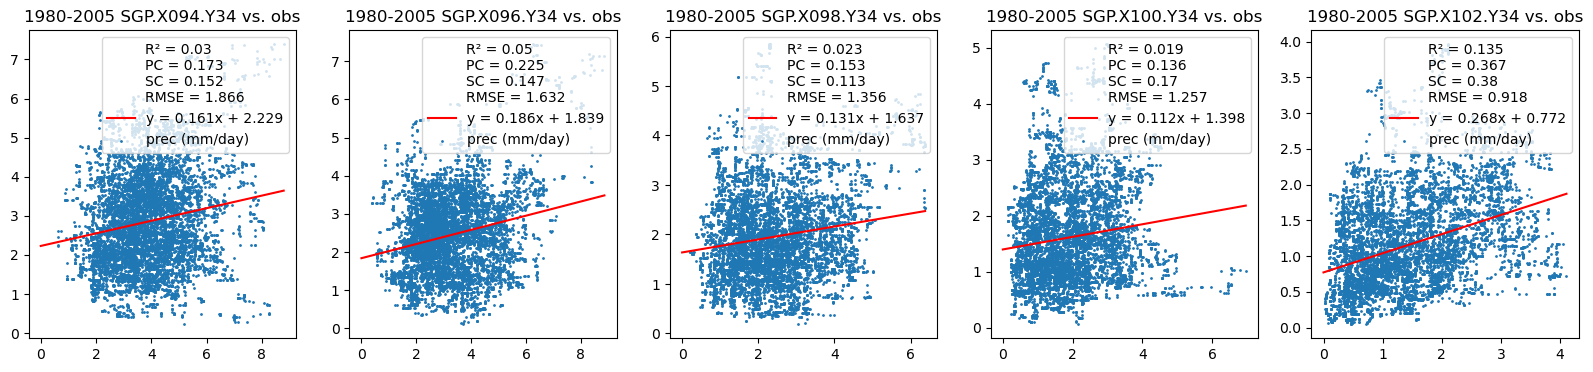

model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y36.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y36.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y36.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y36.nc


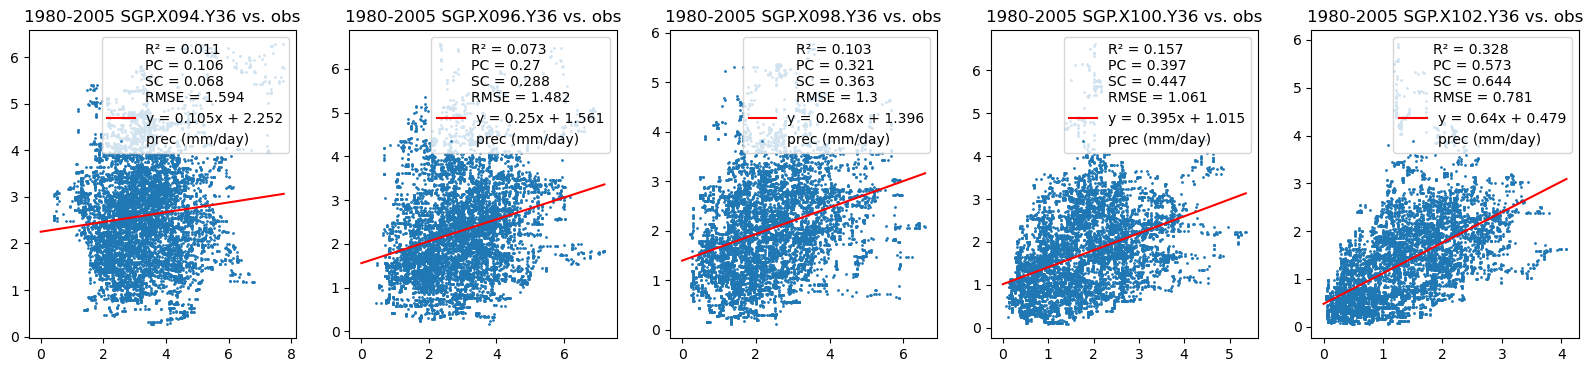

model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y38.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y38.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y38.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y38.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y38.nc


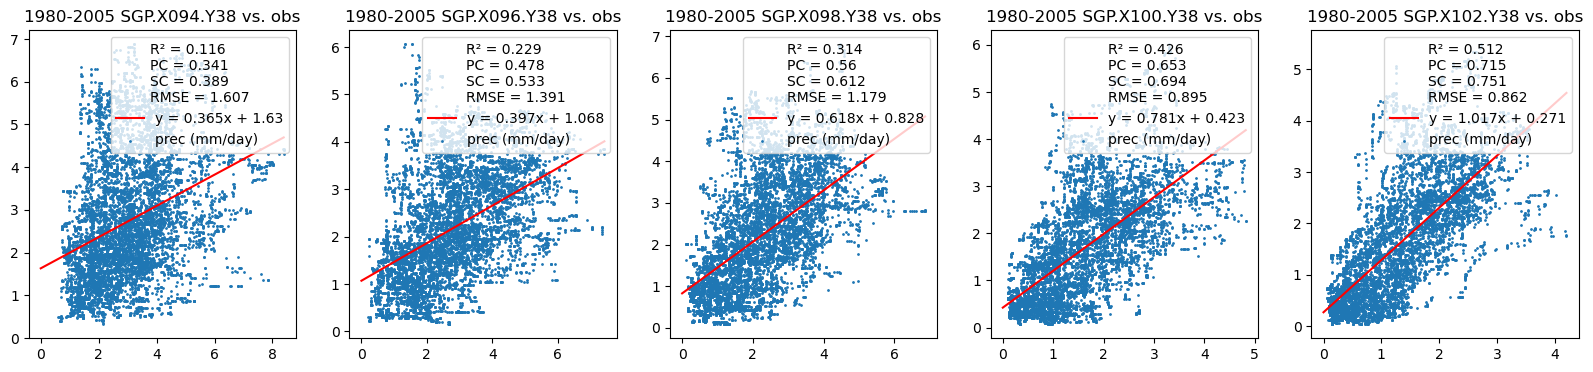

In [189]:
for yy in ['32','34','36','38']:
    #for xx in ['094']:
    fig, axarr = plt.subplots(1, 5, figsize = (20,4))
    for ii,xx in [[0,'094'], [1,'096'], [2,'098'], [3,'100'], [4,'102']]:
        s1 = '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x{}.y{}.nc'.format(xx, yy)
        s2 = '/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x{}.y{}.nc'.format(xx, yy)
        plot_row_avg_r2(s1, s2, 90, axarr[ii])
    plt.show()

model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y32.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y32.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y32.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y32.nc
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y32.nc


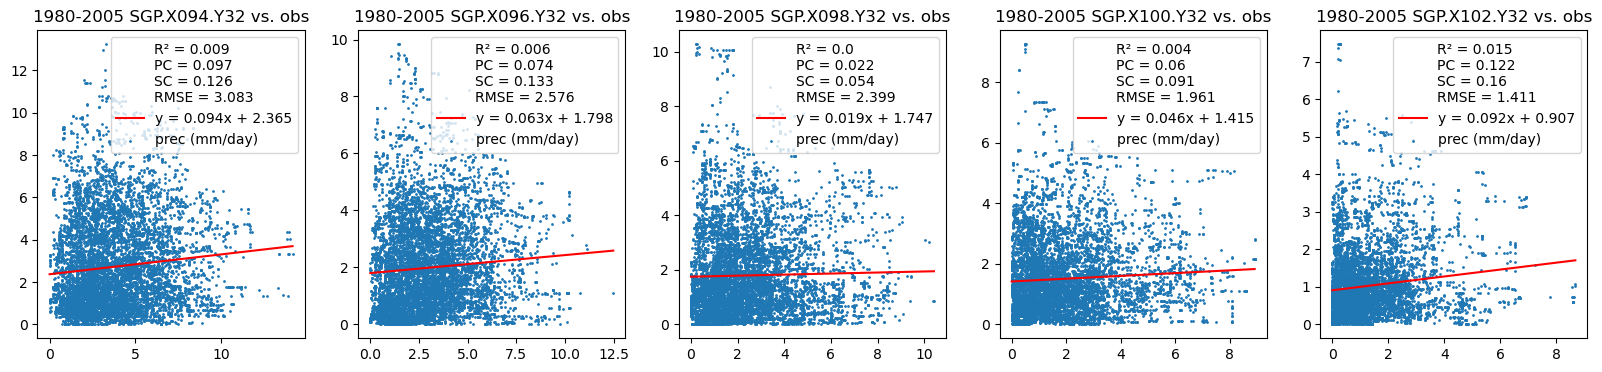

In [187]:
for yy in ['32']:
    #for xx in ['094']:
    fig, axarr = plt.subplots(1, 5, figsize = (20,4))
    for ii,xx in [[0,'094'], [1,'096'], [2,'098'], [3,'100'], [4,'102']]:
        s1 = '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x{}.y{}.nc'.format(xx, yy)
        s2 = '/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x{}.y{}.nc'.format(xx, yy)
        plot_row_avg_r2(s1, s2, 30, axarr[ii])
    plt.show()


### average of all 20 points

In [6]:
def plot2(rs1, rs2, ndays):     
 
    # smooth with 100 day running average    
    rs1 = moving_avg(rs1, ndays)
    rs2 = moving_avg(rs2, ndays)
    


    # plot best fit line
    pc, eq, m, b = linear_regression(rs1,rs2)
    xmaxreg = max(rs1)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(rs2): 
        xmaxreg = (max(rs2)-b) / m
    plt.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    #rowtitle = '.'.join(sigfilename.split('.')[0:4])
    rowtitle = ''
    plt.scatter(rs1, rs2, color="tab:blue", s=1, label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(rs1,rs2)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((rs1-rs2)**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    plt.legend(loc="upper right", title=r2_text)

    # title
    #sigfilename = basename(sigfile)
    #title = sigfilename.split('.')[5] + ' ' + '.'.join(sigfilename.split('.')[7:10])
    title = ''
    plt.title( title.upper()+' vs. obs' )
                
                

    plt.show()


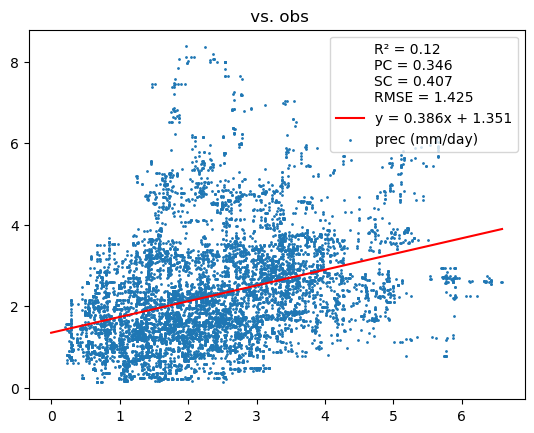

In [7]:
# average of all 20 points
firsttime = True
for xx in ['094','096','098','100','102']:
    for yy in ['32','34','36','38']:
        s1 = '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x{}.y{}.nc'.format(xx, yy)
        s2 = '/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x{}.y{}.nc'.format(xx, yy)
        rs1 = np.array(rainsignal_obs[:,0,0])
        rs2 = np.array(rainsignal[:,0,0])
        rs1[np.isnan(rs1)] = 0.
        rs2[np.isnan(rs2)] = 0.

        if firsttime:
            xsum = rs1
            ysum = rs2
            firsttime = False
        else:
            xsum += rs1
            ysum += rs2

xsum
plot2(xsum/20,ysum/20, 90)


### SGP Average

In [190]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]


In [197]:
# CNN
# 1980-1989
istart = 0
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 
ddv1 = xr.open_dataset('/glade/scratch/dkorytin/runs/2021-06-01_uatm-eraionmpi-ssim-700e_1980-2016/prec_uatm_1980-2016.nc')['prec'][istart:istart+ndays]


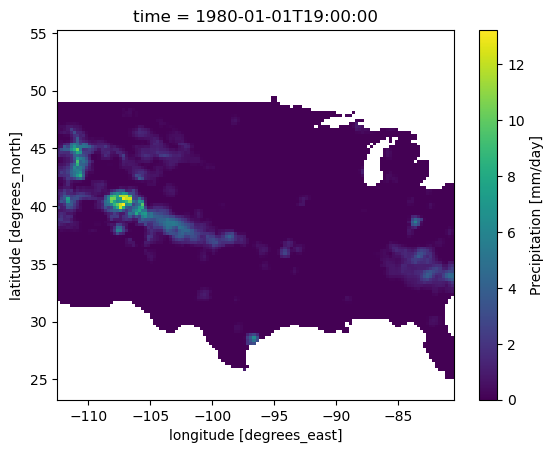

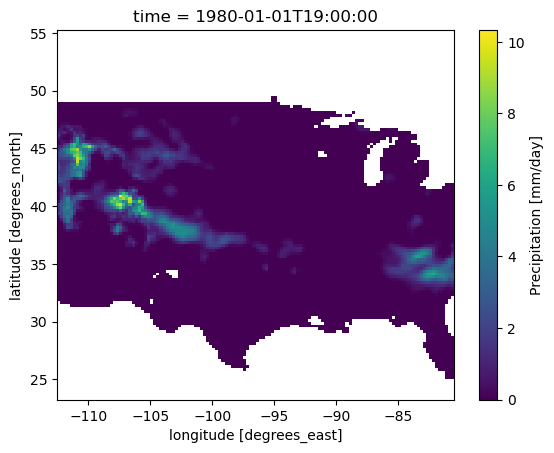

In [198]:
dv1[0].plot()
plt.show()
ddv1[0].plot()
plt.show()

In [296]:
def plot_row_avg_r2_UATM(sigfile, obs_sigfile, ndays, ax, days_offset=10958):     
    # load rain signal
    rainsignal = xr.open_dataset(sigfile)['prec']
    sigfilename = basename(sigfile)
    
    # load obs
    rainsignal_obs = xr.open_dataset(obs_sigfile)['prec']
    
    
    #print(rainsignal['lat'])
    #rainsignal_obs.sel(lat=25., lon=90., method='nearest').plot()



#     rs1 = np.array(rainsignal_obs[:,0,0])
#     rs2 = np.array(rainsignal[:,0,0])

    lat = float(rainsignal_obs['lat'])
    lon = float(rainsignal_obs['lon'])
    print("GGGG", lat, lon)
    
    rs1 = np.array(ddv1.sel(lat=lat, lon=lon, method='nearest'))[days_offset:]
    rs2 = np.array(dv1.sel(lat=lat, lon=lon, method='nearest'))[days_offset:]
    
    
    
    # fix rs2: set nan's to zero
    rs1[np.isnan(rs1)] = 0.
    rs2[np.isnan(rs2)] = 0.

    # smooth with 100 day running average    
    rs1 = moving_avg(rs1, ndays)
    rs2 = moving_avg(rs2, ndays)
    

    print ("model:", sigfilename)


    # plot best fit line
    pc, eq, m, b = linear_regression(rs1,rs2)
    xmaxreg = max(rs1)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(rs2): 
        xmaxreg = (max(rs2)-b) / m
    ax.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    rowtitle = '.'.join(sigfilename.split('.')[0:4])
    ax.scatter(rs1, rs2, color="tab:blue", s=1, label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(rs1,rs2)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((rs1-rs2)**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    ax.legend(loc="upper right", title=r2_text)

    # title
    sigfilename = basename(sigfile)
    title = sigfilename.split('.')[5] + ' ' + '.'.join(sigfilename.split('.')[7:10])
    #ax.title( title.upper()+' vs. obs' )
    ax.set_title(title.upper()+' vs. obs')

GGGG 32.125 -93.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y32.nc
GGGG 32.125 -95.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y32.nc
GGGG 32.125 -97.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y32.nc
GGGG 32.125 -99.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y32.nc
GGGG 32.125 -101.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y32.nc


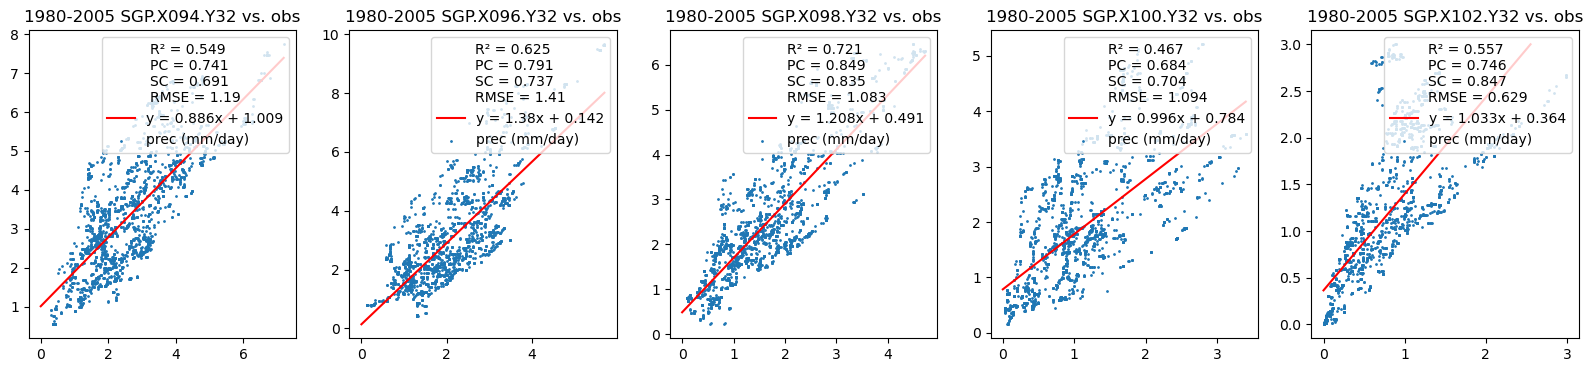

GGGG 34.125 -93.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y34.nc
GGGG 34.125 -95.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y34.nc
GGGG 34.125 -97.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y34.nc
GGGG 34.125 -99.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y34.nc
GGGG 34.125 -101.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y34.nc


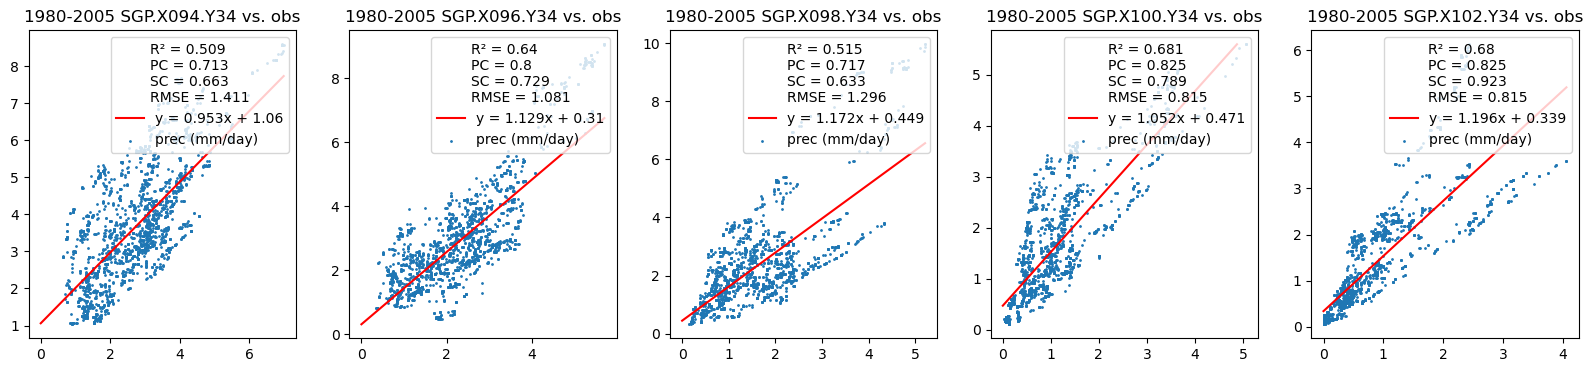

GGGG 36.125 -93.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y36.nc
GGGG 36.125 -95.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y36.nc
GGGG 36.125 -97.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc
GGGG 36.125 -99.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y36.nc
GGGG 36.125 -101.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y36.nc


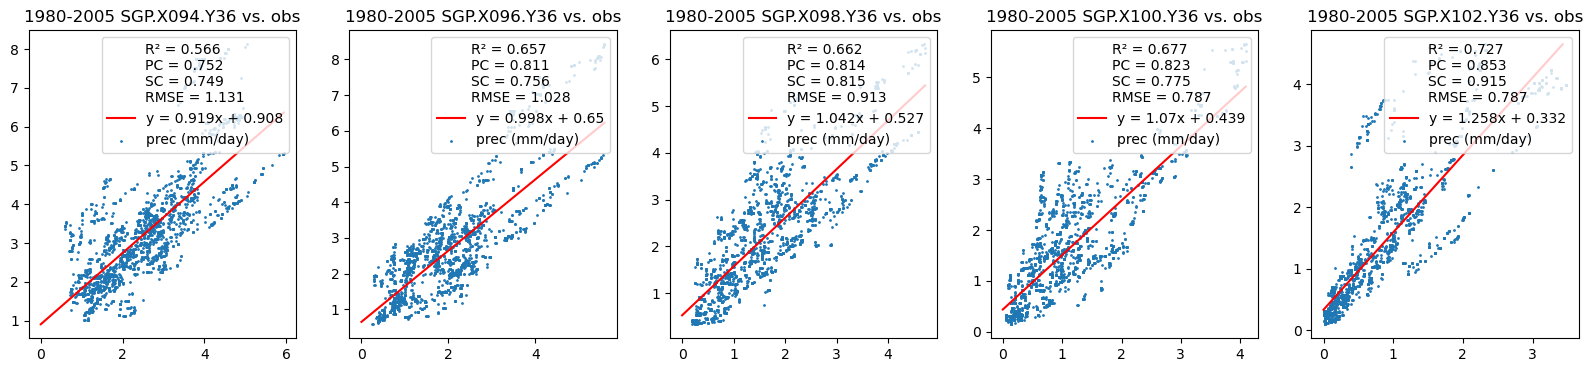

GGGG 38.125 -93.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x094.y38.nc
GGGG 38.125 -95.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x096.y38.nc
GGGG 38.125 -97.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y38.nc
GGGG 38.125 -99.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x100.y38.nc
GGGG 38.125 -101.875
model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x102.y38.nc


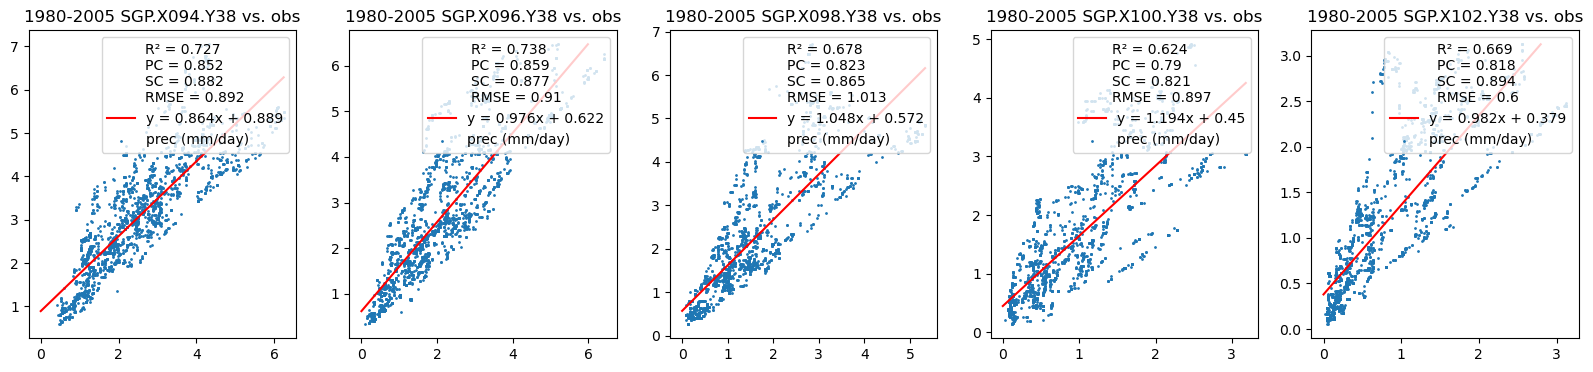

In [300]:
for yy in ['32','34','36','38']:
    #for xx in ['094']:
    fig, axarr = plt.subplots(1, 5, figsize = (20,4))
    for ii,xx in [[0,'094'], [1,'096'], [2,'098'], [3,'100'], [4,'102']]:
        s1 = '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x{}.y{}.nc'.format(xx, yy)
        s2 = '/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x{}.y{}.nc'.format(xx, yy)
        #plot_row_avg_r2_UATM(s1, s2, 1, axarr[ii], days_offset=0)
        plot_row_avg_r2_UATM(s1, s2, 90, axarr[ii], days_offset=10958)
    plt.show()